# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

코더 : 임성범   

데이터셋 : 네이버 영화리뷰

# 0) 라이브러리 호출

In [20]:
import pandas
import konlpy
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf

# 1) 데이터 준비와 확인

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')


# 2) 데이터로더 구성

In [61]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [62]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [63]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

In [73]:
len(index_to_word)

10000

In [65]:
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [66]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [67]:
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [74]:
len(index_to_word)

10000

In [68]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3  # unknown

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     
print(word_to_index['the'])  
print(index_to_word[1909])     

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))

<BOS>
1909
the
더 빙 . . 진짜 짜증 나 네요 목소리


In [75]:
print(get_decoded_sentence(X_train[2], index_to_word))

재 <UNUSED>


In [89]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
(146182, 41)


# 실험 시작

### 1-1 임베딩 학습, LSTM 2개 , Dense 레이어 2개

In [86]:
# 성범
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계
model = tf.keras.Sequential([
    # Embedding 레이어: 입력 시퀀스를 워드 벡터로 변환
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=None),
    
    # 첫 번째 LSTM 레이어
    tf.keras.layers.LSTM(128, return_sequences=True),
    
    # 두 번째 LSTM 레이어
    tf.keras.layers.LSTM(128, return_sequences=False),
    
    # Dense 레이어: 뉴런 수 16, ReLU 활성화 함수
    tf.keras.layers.Dense(64, activation='relu'),
    
    # 출력 레이어: 뉴런 수 1, 시그모이드 활성화 함수 (이진 감성 분석)
    tf.keras.layers.Dense(1, activation='sigmoid')
])



model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         74240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 374,145
Trainable params: 374,145
Non-trainable params: 0
_________________________________________________________________


In [90]:
X_train

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    3],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

In [91]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


#### 훈련 개시

In [92]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 8s 19ms/step - loss: 0.4248 - accuracy: 0.7955 - val_loss: 0.3448 - val_accuracy: 0.8517
Epoch 2/20
266/266 [==============================] - 4s 17ms/step - loss: 0.3316 - accuracy: 0.8593 - val_loss: 0.3431 - val_accuracy: 0.8508
Epoch 3/20
266/266 [==============================] - 4s 17ms/step - loss: 0.3161 - accuracy: 0.8672 - val_loss: 0.3399 - val_accuracy: 0.8540
Epoch 4/20
266/266 [==============================] - 4s 17ms/step - loss: 0.2981 - accuracy: 0.8745 - val_loss: 0.3284 - val_accuracy: 0.8561
Epoch 5/20
266/266 [==============================] - 4s 17ms/step - loss: 0.2752 - accuracy: 0.8853 - val_loss: 0.3261 - val_accuracy: 0.8622
Epoch 6/20
266/266 [==============================] - 4s 17ms/step - loss: 0.2546 - accuracy: 0.8955 - val_loss: 0.3298 - val_accuracy: 0.8546
Epoch 7/20
266/266 [==============================] - 4s 16ms/step - loss: 0.2350 - accuracy: 0.9045 - val_loss: 0.3411 - val_accuracy: 0.8613

In [93]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.7068 - accuracy: 0.8363
[0.7067860960960388, 0.8363407254219055]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


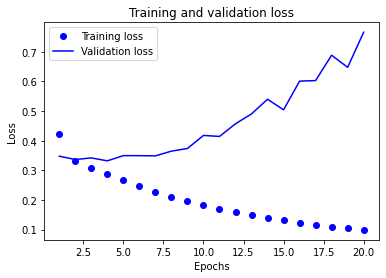

In [58]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

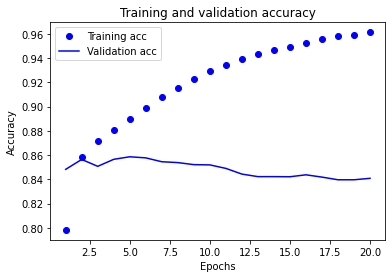

In [59]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-2 양방향 RNN

In [77]:
model_birnn = tf.keras.Sequential([
    # Embedding 레이어: 입력 시퀀스를 워드 벡터로 변환
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=None),
    
    
    # 양방향 RNN 레이어
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128, return_sequences=True)),
    
    # 양방향 RNN 레이어 
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128)),
    
    # Dense 레이어: 뉴런 수 64, ReLU 활성화 함수
    tf.keras.layers.Dense(64, activation='relu'),
    
    # 출력 레이어: 뉴런 수 1, 시그모이드 활성화 함수 (이진 감성 분석)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model_birnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model_birnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         37120     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               98560     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 312,193
Trainable params: 312,193
Non-trainable params: 0
_________________________________________________________________


In [78]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_birnn = model_birnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 39s 136ms/step - loss: 0.4412 - accuracy: 0.7863 - val_loss: 0.3513 - val_accuracy: 0.8460
Epoch 2/20
266/266 [==============================] - 36s 134ms/step - loss: 0.3354 - accuracy: 0.8581 - val_loss: 0.3403 - val_accuracy: 0.8509
Epoch 3/20
266/266 [==============================] - 36s 136ms/step - loss: 0.3086 - accuracy: 0.8709 - val_loss: 0.3477 - val_accuracy: 0.8502
Epoch 4/20
266/266 [==============================] - 36s 135ms/step - loss: 0.2872 - accuracy: 0.8807 - val_loss: 0.3465 - val_accuracy: 0.8462
Epoch 5/20
266/266 [==============================] - 36s 135ms/step - loss: 0.2623 - accuracy: 0.8922 - val_loss: 0.3612 - val_accuracy: 0.8491
Epoch 6/20
266/266 [==============================] - 36s 134ms/step - loss: 0.2362 - accuracy: 0.9046 - val_loss: 0.3895 - val_accuracy: 0.8463
Epoch 7/20
266/266 [==============================] - 36s 136ms/step - loss: 0.2098 - accuracy: 0.9168 - val_loss: 0.4021 - val_ac

In [83]:
model_birnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         37120     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               98560     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 312,193
Trainable params: 312,193
Non-trainable params: 0
_________________________________________________________________


In [94]:
results_birnn = model_birnn.evaluate(X_test,  y_test, verbose=2)

print(results_birnn)

1537/1537 - 19s - loss: 0.8723 - accuracy: 0.8182
[0.8722752928733826, 0.8182151317596436]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


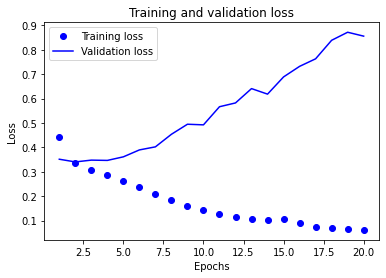

In [81]:
history_birnn_dict = history_birnn.history
print(history_dict.keys())



acc_birnn = history_birnn_dict['accuracy']
val_acc_birnn = history_birnn_dict['val_accuracy']
loss_birnn = history_birnn_dict['loss']
val_loss_birnn = history_birnn_dict['val_loss']

epochs_birnn = range(1, len(acc_birnn) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_birnn, loss_birnn, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss_birnn, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 1.3 양방향 GRU

#### 모델 구성

In [95]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수

# 모델 설계
model_biGRU = tf.keras.Sequential([
    # Embedding 레이어: 입력 시퀀스를 워드 벡터로 변환
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=None),
    
    # 양방향 GRU 레이어
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    
    # 추가적인 양방향 GRU 레이어 (필요한 경우)
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    
    # Dense 레이어: 뉴런 수 64, ReLU 활성화 함수
    tf.keras.layers.Dense(64, activation='relu'),
    
    # 출력 레이어: 뉴런 수 1, 시그모이드 활성화 함수 (이진 감성 분석)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model_biGRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model_biGRU.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         112128    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 585,089
Trainable params: 585,089
Non-trainable params: 0
_________________________________________________________________


In [96]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_biGRU = model_biGRU.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
266/266 - 14s - loss: 0.4155 - accuracy: 0.8038 - val_loss: 0.3596 - val_accuracy: 0.8428
Epoch 2/20
266/266 - 9s - loss: 0.3333 - accuracy: 0.8575 - val_loss: 0.3407 - val_accuracy: 0.8530
Epoch 3/20
266/266 - 9s - loss: 0.3112 - accuracy: 0.8688 - val_loss: 0.3309 - val_accuracy: 0.8564
Epoch 4/20
266/266 - 9s - loss: 0.2865 - accuracy: 0.8804 - val_loss: 0.3224 - val_accuracy: 0.8599
Epoch 5/20
266/266 - 9s - loss: 0.2614 - accuracy: 0.8921 - val_loss: 0.3249 - val_accuracy: 0.8586
Epoch 6/20
266/266 - 9s - loss: 0.2404 - accuracy: 0.9019 - val_loss: 0.3256 - val_accuracy: 0.8565
Epoch 7/20
266/266 - 9s - loss: 0.2213 - accuracy: 0.9115 - val_loss: 0.3441 - val_accuracy: 0.8568
Epoch 8/20
266/266 - 9s - loss: 0.2064 - accuracy: 0.9182 - val_loss: 0.3605 - val_accuracy: 0.8528
Epoch 9/20
266/266 - 9s - loss: 0.1912 - accuracy: 0.9256 - val_loss: 0.3962 - val_accuracy: 0.8553
Epoch 10/20
266/266 - 9s - loss: 0.1770 - accuracy: 0.9316 - val_loss: 0.4326 - val_accuracy: 0.848

In [97]:
results_biGRU = model_biGRU.evaluate(X_test,  y_test, verbose=2)

print(results_biGRU)

1537/1537 - 6s - loss: 0.7844 - accuracy: 0.8364
[0.7844418883323669, 0.8363610506057739]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


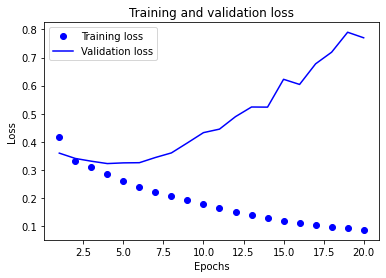

In [98]:
history_biGRU_dict = history_biGRU.history
print(history_dict.keys())



acc_biGRU = history_biGRU_dict['accuracy']
val_acc_biGRU = history_biGRU_dict['val_accuracy']
loss_biGRU = history_biGRU_dict['loss']
val_loss_biGRU = history_biGRU_dict['val_loss']

epochs_biGRU = range(1, len(acc_biGRU) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_biGRU, loss_biGRU, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_biGRU, val_loss_biGRU, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

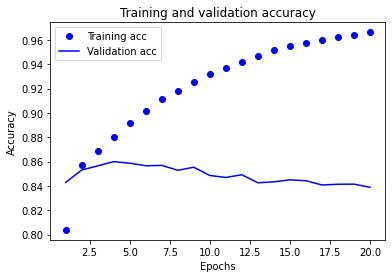

In [99]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_biGRU, acc_biGRU, 'bo', label='Training acc')
plt.plot(epochs_biGRU, val_acc_biGRU, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 임베딩 레이어 분석

### 사전 훈련된 모델 불러오기

In [112]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# Word2Vec 모델 파일 경로 설정 (예시)
word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'

# Word2Vec 모델 로드
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [122]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = word_vectors.vector_size  # Word2Vec에서 가져온 벡터 크기

# 단어 사전 생성
word_to_index = {word: idx + 1 for idx, word in enumerate(word_vectors.wv.index_to_key)}
word_to_index["<PAD>"] = 0  # 패딩 토큰 추가

# 초기화된 임베딩 행렬 생성 (모든 값이 0인 행렬로 초기화)
embedding_matrix = np.zeros((len(word_to_index), word_vector_dim))

# 임베딩 행렬에 Word2Vec 벡터 삽입
for word, index in word_to_index.items():
    if word in word_vectors.wv.key_to_index:  # key_to_index를 사용하여 단어가 존재하는지 확인
        embedding_matrix[index] = word_vectors.wv[word]

# Embedding 레이어 초기화
embedding_layer = tf.keras.layers.Embedding(input_dim=len(word_to_index),
                                            output_dim=word_vector_dim,
                                            weights=[embedding_matrix],
                                            trainable=False,  # 사전 학습된 임베딩을 고정
                                            input_length=None)

In [129]:
model = tf.keras.Sequential([
    embedding_layer,  # 사전 학습된 Word2Vec 임베딩을 사용하는 Embedding 레이어
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 이진 분류용 출력 레이어
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         30296100  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 128)         84480     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 30,487,717
Trainable params: 191,617
Non-trainable params: 30,296,100
____________________________________

In [130]:
history_word2vec = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
266/266 - 10s - loss: 0.4916 - accuracy: 0.7517 - val_loss: 0.4110 - val_accuracy: 0.8077
Epoch 2/20
266/266 - 5s - loss: 0.3984 - accuracy: 0.8140 - val_loss: 0.3782 - val_accuracy: 0.8268
Epoch 3/20
266/266 - 5s - loss: 0.3642 - accuracy: 0.8349 - val_loss: 0.3615 - val_accuracy: 0.8352
Epoch 4/20
266/266 - 5s - loss: 0.3420 - accuracy: 0.8464 - val_loss: 0.3620 - val_accuracy: 0.8414
Epoch 5/20
266/266 - 5s - loss: 0.3230 - accuracy: 0.8566 - val_loss: 0.3587 - val_accuracy: 0.8423
Epoch 6/20
266/266 - 5s - loss: 0.3067 - accuracy: 0.8659 - val_loss: 0.3627 - val_accuracy: 0.8404
Epoch 7/20
266/266 - 5s - loss: 0.2903 - accuracy: 0.8733 - val_loss: 0.3558 - val_accuracy: 0.8425
Epoch 8/20
266/266 - 5s - loss: 0.2769 - accuracy: 0.8812 - val_loss: 0.3796 - val_accuracy: 0.8413
Epoch 9/20
266/266 - 5s - loss: 0.2652 - accuracy: 0.8867 - val_loss: 0.3625 - val_accuracy: 0.8450
Epoch 10/20
266/266 - 5s - loss: 0.2525 - accuracy: 0.8931 - val_loss: 0.3741 - val_accuracy: 0.841

In [131]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.5273 - accuracy: 0.8322
[0.5272683501243591, 0.832190752029419]


## 회고
뭔가 시간이 많은거 같으면서도 추석때 다까먹어서 다시 감을 잡는데 오래걸린거같다. 큰일났다 오늘 다시 공부해야겠다.

성능이 계속 안나와서 계속 바꿔가며 하는데도 안되는거같아서 포기할뻔했다.